# Librerias

In [ ]:
import numpy as np
import random
from pymoo.core.problem import Problem
from pymoo.problems import get_problem
from pymoo.visualization.util import plot
from pymoo.visualization.scatter import Scatter
from pymoo.indicators.hv import Hypervolume
from pymoo.util.nds.non_dominated_sorting import NonDominatedSorting

from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.algorithms.moo.spea2 import SPEA2

from pymoo.optimize import minimize
import matplotlib.pyplot as plt

# TSPMO

In [11]:
class TSPProblem(Problem):
    def __init__(self, n_cities, seed=50):
        # Define the number of variables (cities) and objectives (time and distance)
        super().__init__(n_var=n_cities, n_obj=2, n_constr=0, xl=0, xu=1)
        
        # Initialize the random seed for reproducibility
        if seed is not None:
            np.random.seed(seed)
        
        # Generate random distances and times between cities
        self.distances = np.random.uniform(0, 100, size=(n_cities, n_cities))
        self.distances = (self.distances + self.distances.T) / 2
        self.times = np.random.uniform(0, 300, size=(n_cities, n_cities))
        random.seed(None)
        
        # Ensure the diagonal is zero (distance/time from a city to itself is zero)
        np.fill_diagonal(self.distances, 0)
        np.fill_diagonal(self.times, 0)

    def _evaluate(self, x, out, *args, **kwargs):
        # Calculate the total distance and time for each solution in x
        distances = []
        times = []
        
        for route in x:
            perm = np.argsort(route)
            total_distance = 0
            total_time = 0
            
            for i in range(len(perm) - 1):
                total_distance += self.distances[perm[i], perm[i+1]]
                total_time += self.times[perm[i], perm[i+1]]
            
            # Add distance and time from last city back to the first city
            total_distance += self.distances[perm[-1], perm[0]]
            total_time += self.times[perm[-1], perm[0]]
            
            distances.append(total_distance)
            times.append(total_time)
        
        out["F"] = np.column_stack([distances, times])

In [12]:
problem = TSPProblem(100)
print(np.shape(problem.distances))
print(np.shape(problem.times))

(100, 100)
(100, 100)


## Métricas

In [27]:
def compute_reference_point(*fronts, factor=1.1):
    all_points = np.vstack(fronts)
    return np.max(all_points, axis=0) * factor

In [28]:
def calculate_metrics(front, ref_point):
    """
    Calcula métricas estándar para un frente de Pareto:
    - Hipervolumen (HV)
    - Dispersión (SPR, Zitzler)
    - Espaciado (SPA, Schott)
    """

    # Asegurar frente no dominado
    nds = NonDominatedSorting()
    nd_idx = nds.do(front, only_non_dominated_front=True)
    F = front[nd_idx]

    # 1. Hipervolumen
    hv = Hypervolume(ref_point).do(F)

    # 2. Dispersión (Zitzler)
    if len(F) > 1:
        spr = np.linalg.norm(np.max(F, axis=0) - np.min(F, axis=0))
    else:
        spr = 0.0

    # 3. Espaciado (Schott)
    if len(F) > 1:
        D = np.linalg.norm(F[:, None, :] - F[None, :, :], axis=-1)
        np.fill_diagonal(D, np.inf)
        spa = np.mean(np.min(D, axis=1))
    else:
        spa = 0.0

    return hv, spr, spa

## NSGA2

## SPEA2

## Algoritmo propuesto

In [14]:
# Genera población inicial aleatoria
def create(pop_size, n_cities):
    return np.random.rand(pop_size, n_cities)

# Evalúa una población para un problema TSP multiobjetivo.
def evaluate_population(problem, population):
    x = np.array(population)
    out = {}
    problem._evaluate(x, out)
    return out["F"]

# Calcula la crowding distance para un conjunto de soluciones multiobjetivo.
def compute_crowding_distance(F):
    n_solutions, n_objectives = F.shape
    crowding = np.zeros(n_solutions)

    for m in range(n_objectives):
        # Ordenar soluciones según el objetivo m
        sorted_idx = np.argsort(F[:, m])
        sorted_values = F[sorted_idx, m]

        # Fronteras siempre infinitas
        crowding[sorted_idx[0]] = np.inf
        crowding[sorted_idx[-1]] = np.inf

        # Normalización
        f_min = sorted_values[0]
        f_max = sorted_values[-1]
        denom = f_max - f_min

        if denom == 0:
            continue

        # Soluciones intermedias
        for i in range(1, n_solutions - 1):
            crowding[sorted_idx[i]] += (
                (sorted_values[i + 1] - sorted_values[i - 1]) / denom
            )

    return crowding

In [15]:
# Selección por torneo multiobjetivo basada en dominancia y crowding distance.
def tournament_selection(population, F, n_parents, T=2):
    parents = []

    for _ in range(n_parents):
        # Selección aleatoria del torneo
        tournament_idx = np.random.choice(len(population), size=T, replace=False)
        F_tournament = F[tournament_idx]

        # Ranking por dominancia
        nds = NonDominatedSorting()
        fronts = nds.do(F_tournament)
        first_front = fronts[0]

        if len(first_front) == 1:
            winner_idx = first_front[0]
        else:
            # Empate → crowding distance
            crowding = compute_crowding_distance(F_tournament)
            winner_idx = first_front[np.argmax(crowding[first_front])]

        parents.append(population[tournament_idx[winner_idx]])

    return np.array(parents)

# Mantiene el frente no dominado truncado por crowding distance.
def keep_nondominated_diverse(population, F, max_size):
    nds = NonDominatedSorting()
    first_front_idx = nds.do(F, only_non_dominated_front=True)

    pop_nd = population[first_front_idx]
    F_nd = F[first_front_idx]

    if len(pop_nd) <= max_size:
        return pop_nd

    # Truncado por crowding
    crowding = compute_crowding_distance(F_nd)
    selected = np.argsort(crowding)[-max_size:]

    return pop_nd[selected]

### Cruze

In [16]:
# Realiza un cruce aritmético simple con probabilidad pcross.
def arithmetic_crossover(parent1, parent2, pcross):
    # Si no se hace cruce, se devuelve copia
    if np.random.rand() >= pcross:
        return parent1.copy(), parent2.copy()

    alpha = np.random.rand()

    child1 = alpha * parent1 + (1.0 - alpha) * parent2
    child2 = alpha * parent2 + (1.0 - alpha) * parent1

    return np.clip(child1, 0.0, 1.0), np.clip(child2, 0.0, 1.0)

# Simulated Binary Crossover (SBX) para variables reales en [0,1]. eta_c controla la explotativilidad.
def sbx_crossover(parent1, parent2, pcross=0.9, eta_c=15):
    if np.random.rand() >= pcross:
            return parent1.copy(), parent2.copy()

    n_var = len(parent1)
    child1 = np.empty(n_var)
    child2 = np.empty(n_var)

    for i in range(n_var):
        x1, x2 = parent1[i], parent2[i]

        if np.abs(x1 - x2) < 1e-14:
            child1[i] = x1
            child2[i] = x2
            continue

        if x1 > x2:
            x1, x2 = x2, x1

        rand = np.random.rand()

        beta = 1.0 + 2.0 * (x1 - 0.0) / (x2 - x1)
        alpha = 2.0 - beta ** (-(eta_c + 1.0))
        betaq = (rand * alpha) ** (1.0 / (eta_c + 1.0)) if rand <= 1.0 / alpha \
                else (1.0 / (2.0 - rand * alpha)) ** (1.0 / (eta_c + 1.0))

        c1 = 0.5 * ((x1 + x2) - betaq * (x2 - x1))

        beta = 1.0 + 2.0 * (1.0 - x2) / (x2 - x1)
        alpha = 2.0 - beta ** (-(eta_c + 1.0))
        betaq = (rand * alpha) ** (1.0 / (eta_c + 1.0)) if rand <= 1.0 / alpha \
                else (1.0 / (2.0 - rand * alpha)) ** (1.0 / (eta_c + 1.0))

        c2 = 0.5 * ((x1 + x2) + betaq * (x2 - x1))

        c1, c2 = np.clip(c1, 0.0, 1.0), np.clip(c2, 0.0, 1.0)

        if np.random.rand() < 0.5:
            child1[i], child2[i] = c2, c1
        else:
            child1[i], child2[i] = c1, c2

    return child1, child2

# BLX-alpha crossover para variables continuas en [0,1]. alpha: factor de mezclado.
def blx_alpha_crossover(parent1, parent2, pcross=0.9, alpha=0.5):
    if np.random.rand() >= pcross:
        return parent1.copy(), parent2.copy()

    n_var = len(parent1)
    child1 = np.empty(n_var)
    child2 = np.empty(n_var)

    for i in range(n_var):
        cmin = min(parent1[i], parent2[i])
        cmax = max(parent1[i], parent2[i])
        diff = cmax - cmin

        lower = cmin - alpha * diff
        upper = cmax + alpha * diff

        child1[i] = np.clip(np.random.uniform(lower, upper), 0.0, 1.0)
        child2[i] = np.clip(np.random.uniform(lower, upper), 0.0, 1.0)

    return child1, child2

### Mutation

In [17]:
# Polynomial mutation para variables reales en [0,1].
def polynomial_mutation(child, pmut=0.1, eta_m=20):
    mutant = child.copy()
    n_var = len(mutant)

    for i in range(n_var):
        if np.random.rand() < pmut:
            x = mutant[i]

            delta1 = x
            delta2 = 1.0 - x
            rand = np.random.rand()
            mut_pow = 1.0 / (eta_m + 1.0)

            if rand < 0.5:
                xy = 1.0 - delta1
                val = 2.0 * rand + (1.0 - 2.0 * rand) * (xy ** (eta_m + 1.0))
                deltaq = val ** mut_pow - 1.0
            else:
                xy = 1.0 - delta2
                val = 2.0 * (1.0 - rand) + 2.0 * (rand - 0.5) * (xy ** (eta_m + 1.0))
                deltaq = 1.0 - val ** mut_pow

            mutant[i] = np.clip(x + deltaq, 0.0, 1.0)

    return mutant

# Mutación uniforme: reemplaza el gen por un valor aleatorio en [0,1].
def uniform_mutation(individual, pmut):
    mutant = individual.copy()

    for i in range(len(mutant)):
        if np.random.rand() < pmut:
            mutant[i] = np.random.rand()

    return mutant

# Mutación gaussiana para random keys.
def gaussian_mutation(individual, pmut, sigma=0.1):
    mutant = individual.copy()

    for i in range(len(mutant)):
        if np.random.rand() < pmut:
            mutant[i] += np.random.normal(0.0, sigma)
            mutant[i] = np.clip(mutant[i], 0.0, 1.0)

    return mutant

MUTATION_OPERATORS = [
    uniform_mutation,
    gaussian_mutation,
    polynomial_mutation
]

# Aplica aleatoriamente uno de los operadores de mutación disponibles.
def mutate(individual, pmut):
    operator = np.random.choice(MUTATION_OPERATORS)
    return operator(individual, pmut)

### Experimentos

In [18]:
# Algoritmo genético multiobjetivo para TSP basado en random keys. Controlado por número máximo de evaluaciones de fitness.
def evolve(
    problem: TSPProblem,
    max_evals: int,
    n_individuals: int,
    crossover_op,
    mutation_op,
    pcross: float,
    pmut: float,
    trace: int = 100,
    T: int = 2,
    elitism: bool = True,
    crossover_params=None,
    mutation_params=None
):

    if crossover_params is None:
        crossover_params = {}
    if mutation_params is None:
        mutation_params = {}

    # Inicialización
    population = create(n_individuals, problem.n_var)
    F = evaluate_population(problem, population)

    evals = len(population)
    generation = 0
    nds = NonDominatedSorting()

    while evals < max_evals:
        generation += 1

        # Selección
        parents = tournament_selection(
            population, F, n_parents=n_individuals, T=T
        )

        offspring = []

        while len(offspring) < n_individuals:
            p1, p2 = random.sample(list(parents), 2)

            # Cruce (genérico)
            c1, c2 = crossover_op(
                p1, p2, pcross, **crossover_params
            )

            # Mutación (genérica)
            c1 = mutation_op(c1, pmut, **mutation_params)
            c2 = mutation_op(c2, pmut, **mutation_params)

            offspring.append(c1)
            if len(offspring) < n_individuals:
                offspring.append(c2)

        offspring = np.array(offspring)

        # Evaluación
        F_off = evaluate_population(problem, offspring)
        evals += len(offspring)

        # Reemplazo
        if elitism:
            combined_pop = np.vstack((population, offspring))
            combined_F = np.vstack((F, F_off))

            population = keep_nondominated_diverse(
                combined_pop, combined_F, max_size=n_individuals
            )
            F = evaluate_population(problem, population)
            evals += len(population)
        else:
            population = offspring
            F = F_off

        # Traza
        if generation == 1 or generation % trace == 0:
            nd_front = nds.do(F, only_non_dominated_front=True)
            print(
                f"Gen {generation} | "
                f"Evals {evals}/{max_evals} | "
                f"No dominadas: {len(nd_front)}"
            )

        if evals >= max_evals:
            break

    return population, F

In [22]:
import pandas as pd

# Guarda el frente de Pareto en el formato del enunciado.
def save_pareto_front(F, filename):
    nds = NonDominatedSorting()
    nd_idx = nds.do(F, only_non_dominated_front=True)

    F_pareto = F[nd_idx]

    df = pd.DataFrame(
        F_pareto,
        columns=["objective1", "objective2"]
    )

    df.to_csv(filename, index=False)

#### Experimento 1 – Aritmético + Uniforme

In [19]:
pop, F = evolve(
    problem=problem,
    max_evals=100_000,
    n_individuals=100,
    crossover_op=arithmetic_crossover,
    mutation_op=uniform_mutation,
    pcross=0.9,
    pmut=0.2
)

Gen 1 | Evals 204/100000 | No dominadas: 4
Gen 100 | Evals 11162/100000 | No dominadas: 12
Gen 200 | Evals 22563/100000 | No dominadas: 14
Gen 300 | Evals 33912/100000 | No dominadas: 11
Gen 400 | Evals 44954/100000 | No dominadas: 8
Gen 500 | Evals 55999/100000 | No dominadas: 11
Gen 600 | Evals 67264/100000 | No dominadas: 13
Gen 700 | Evals 78600/100000 | No dominadas: 11
Gen 800 | Evals 89595/100000 | No dominadas: 9


In [24]:
save_pareto_front(F, "Logs/CodGrupo_TSPMO_Aritm_Uniform.csv")

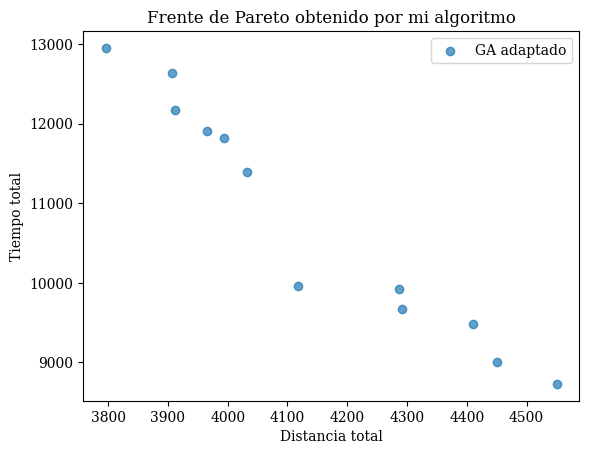

In [ ]:
plt.figure()
plt.scatter(F[:, 0], F[:, 1], label="GA adaptado", alpha=0.7)
plt.xlabel("Distancia total")
plt.ylabel("Tiempo total")
plt.legend()
plt.title("Frente de Pareto obtenido por mi algoritmo")
plt.show()

In [29]:
ref_point = compute_reference_point(F)
hv, spr, spa = calculate_metrics(F, ref_point)
print(f"Hipervolumen: {hv}")
print(f"Dispersión (SPR): {spr}")
print(f"Espaciado (SPA): {spa}")

Hipervolumen: 5177239.366153552
Dispersión (SPR): 4285.2196747545195
Espaciado (SPA): 242.8013364490486


#### Experimento 2 – BLX-α + Gaussiana

In [34]:
pop, F = evolve(
    problem=problem,
    max_evals=100_000,
    n_individuals=100,
    crossover_op=blx_alpha_crossover,
    mutation_op=gaussian_mutation,
    pcross=0.7,
    pmut=0.1,
    crossover_params={"alpha": 0.5},
    mutation_params={"sigma": 0.1}
)

Gen 1 | Evals 206/100000 | No dominadas: 6
Gen 100 | Evals 11886/100000 | No dominadas: 21
Gen 200 | Evals 23482/100000 | No dominadas: 18
Gen 300 | Evals 35402/100000 | No dominadas: 22
Gen 400 | Evals 47568/100000 | No dominadas: 23
Gen 500 | Evals 59947/100000 | No dominadas: 21
Gen 600 | Evals 72225/100000 | No dominadas: 22
Gen 700 | Evals 84291/100000 | No dominadas: 22
Gen 800 | Evals 96682/100000 | No dominadas: 25


In [35]:
save_pareto_front(F, "Logs/CodGrupo_TSPMO_BLXa_Gaussian.csv")

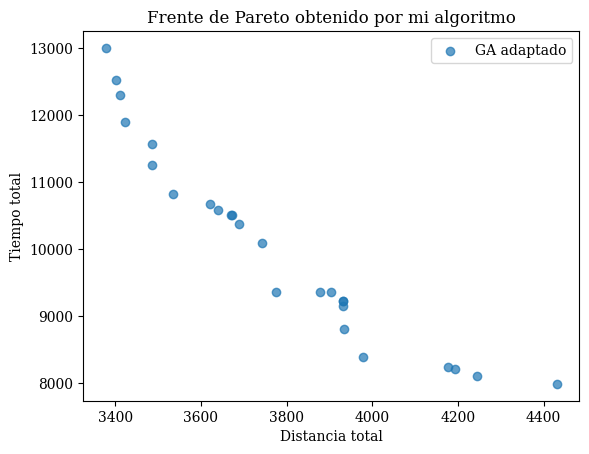

In [36]:
plt.figure()
plt.scatter(F[:, 0], F[:, 1], label="GA adaptado", alpha=0.7)
plt.xlabel("Distancia total")
plt.ylabel("Tiempo total")
plt.legend()
plt.title("Frente de Pareto obtenido por mi algoritmo")
plt.show()

In [37]:
ref_point = compute_reference_point(F)
hv, spr, spa = calculate_metrics(F, ref_point)
print(f"Hipervolumen: {hv}")
print(f"Dispersión (SPR): {spr}")
print(f"Espaciado (SPA): {spa}")

Hipervolumen: 7839172.38066896
Dispersión (SPR): 5122.9751690081885
Espaciado (SPA): 156.1263706802889


#### Experimento 3 – BLX-α + Mutate

In [ ]:
pop, F = evolve(
    problem=problem,
    max_evals=100_000,
    n_individuals=100,
    crossover_op=blx_alpha_crossover,
    mutation_op=mutate,
    pcross=0.8,
    pmut=0.01,
    T = 3,
    crossover_params={"alpha": 0.5},
)

Gen 1 | Evals 207/100000 | No dominadas: 7
Gen 100 | Evals 11579/100000 | No dominadas: 24
Gen 200 | Evals 23187/100000 | No dominadas: 20
Gen 300 | Evals 35017/100000 | No dominadas: 20
Gen 400 | Evals 47263/100000 | No dominadas: 26
Gen 500 | Evals 59477/100000 | No dominadas: 22
Gen 600 | Evals 71636/100000 | No dominadas: 21
Gen 700 | Evals 83722/100000 | No dominadas: 21
Gen 800 | Evals 96067/100000 | No dominadas: 24


In [42]:
save_pareto_front(F, "Logs/CodGrupo_TSPMO_BLXa_Mutate.csv")

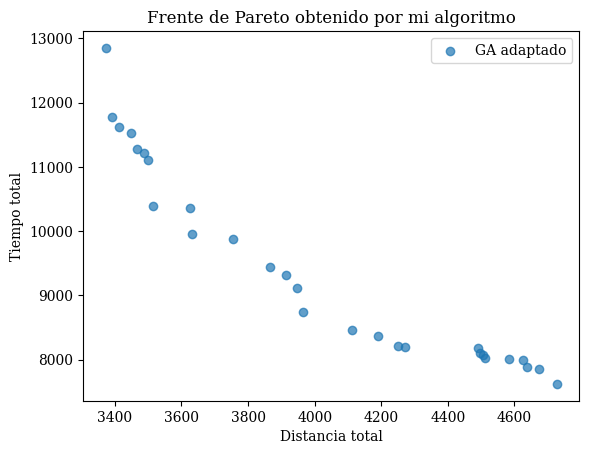

In [43]:
plt.figure()
plt.scatter(F[:, 0], F[:, 1], label="GA adaptado", alpha=0.7)
plt.xlabel("Distancia total")
plt.ylabel("Tiempo total")
plt.legend()
plt.title("Frente de Pareto obtenido por mi algoritmo")
plt.show()

In [44]:
ref_point = compute_reference_point(F)
hv, spr, spa = calculate_metrics(F, ref_point)
print(f"Hipervolumen: {hv}")
print(f"Dispersión (SPR): {spr}")
print(f"Espaciado (SPA): {spa}")

Hipervolumen: 9805259.654475586
Dispersión (SPR): 5404.7522395571295
Espaciado (SPA): 139.66443691715054


#### Experimento 4 - SBX + Polynomial

In [45]:
pop, F = evolve(
    problem=problem,
    max_evals=100_000,
    n_individuals=100,
    crossover_op=sbx_crossover,
    mutation_op=polynomial_mutation,
    pcross=0.9,
    pmut=0.1,
    T=2,
    elitism=True,
    crossover_params={"eta_c": 20},
    mutation_params={"eta_m": 20}
)

Gen 1 | Evals 205/100000 | No dominadas: 5
Gen 100 | Evals 11083/100000 | No dominadas: 10
Gen 200 | Evals 22470/100000 | No dominadas: 12
Gen 300 | Evals 33959/100000 | No dominadas: 9
Gen 400 | Evals 45079/100000 | No dominadas: 14
Gen 500 | Evals 56560/100000 | No dominadas: 16
Gen 600 | Evals 68612/100000 | No dominadas: 21
Gen 700 | Evals 80502/100000 | No dominadas: 19
Gen 800 | Evals 92336/100000 | No dominadas: 19


In [46]:
save_pareto_front(F, "Logs/CodGrupo_TSPMO_SBX_Polynomial.csv")

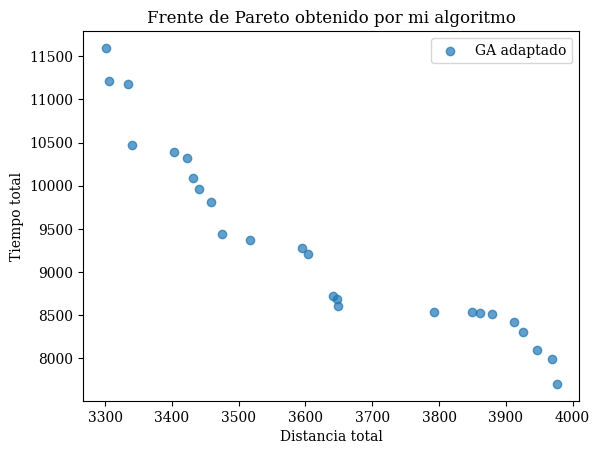

In [47]:
plt.figure()
plt.scatter(F[:, 0], F[:, 1], label="GA adaptado", alpha=0.7)
plt.xlabel("Distancia total")
plt.ylabel("Tiempo total")
plt.legend()
plt.title("Frente de Pareto obtenido por mi algoritmo")
plt.show()

In [48]:
ref_point = compute_reference_point(F)
hv, spr, spa = calculate_metrics(F, ref_point)
print(f"Hipervolumen: {hv}")
print(f"Dispersión (SPR): {spr}")
print(f"Espaciado (SPA): {spa}")

Hipervolumen: 4391156.83758736
Dispersión (SPR): 3949.418239977637
Espaciado (SPA): 95.68539306037623


#### Experimento 5 - SBX + Polynomial (II)

In [56]:
pop, F = evolve(
    problem=problem,
    max_evals=100_000,
    n_individuals=100,
    crossover_op=sbx_crossover,
    mutation_op=polynomial_mutation,
    pcross=0.9,
    pmut=0.01,
    T=2,
    elitism=True,
    crossover_params={"eta_c": 20},
    mutation_params={"eta_m": 20}
)

Gen 1 | Evals 208/100000 | No dominadas: 8
Gen 100 | Evals 14242/100000 | No dominadas: 36
Gen 200 | Evals 31648/100000 | No dominadas: 96
Gen 300 | Evals 51102/100000 | No dominadas: 100
Gen 400 | Evals 70711/100000 | No dominadas: 100
Gen 500 | Evals 90304/100000 | No dominadas: 100


In [57]:
save_pareto_front(F, "Logs/CodGrupo_TSPMO_SBX_Polynomial_II.csv")

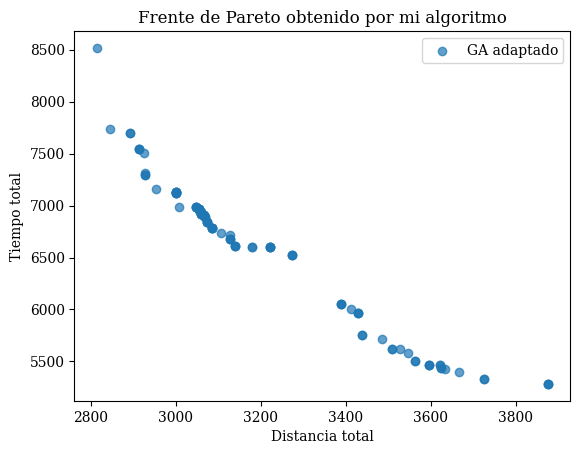

In [58]:
plt.figure()
plt.scatter(F[:, 0], F[:, 1], label="GA adaptado", alpha=0.7)
plt.xlabel("Distancia total")
plt.ylabel("Tiempo total")
plt.legend()
plt.title("Frente de Pareto obtenido por mi algoritmo")
plt.show()

In [59]:
ref_point = compute_reference_point(F)
hv, spr, spa = calculate_metrics(F, ref_point)
print(f"Hipervolumen: {hv}")
print(f"Dispersión (SPR): {spr}")
print(f"Espaciado (SPA): {spa}")

Hipervolumen: 4821661.738651313
Dispersión (SPR): 3403.985770746556
Espaciado (SPA): 12.662906731284176


## Comparativa nuestro AG vs NSGA-II & SPEA-II

In [60]:
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize

pop, F_ours = evolve(
    problem=problem,
    max_evals=100_000,
    n_individuals=100,
    crossover_op=sbx_crossover,
    mutation_op=polynomial_mutation,
    pcross=0.9,
    pmut=0.01,
    T=2,
    elitism=True,
    crossover_params={"eta_c": 20},
    mutation_params={"eta_m": 20}
)

nds = NonDominatedSorting()
idx_ours = nds.do(F_ours, only_non_dominated_front=True)
F_ours_pareto = F_ours[idx_ours]

res_nsga2 = minimize(
    problem,
    NSGA2(pop_size=100),
    termination=("n_eval", 100_000),
    seed=42,
    verbose=False
)

F_nsga2_pareto = res_nsga2.F

res_spea2 = minimize(
    problem,
    SPEA2(pop_size=100),
    termination=("n_eval", 100_000),
    seed=42,
    verbose=False
)

F_spea2_pareto = res_spea2.F

Gen 1 | Evals 206/100000 | No dominadas: 6
Gen 100 | Evals 14990/100000 | No dominadas: 34
Gen 200 | Evals 33295/100000 | No dominadas: 97
Gen 300 | Evals 52882/100000 | No dominadas: 60
Gen 400 | Evals 71956/100000 | No dominadas: 100
Gen 500 | Evals 91955/100000 | No dominadas: 100


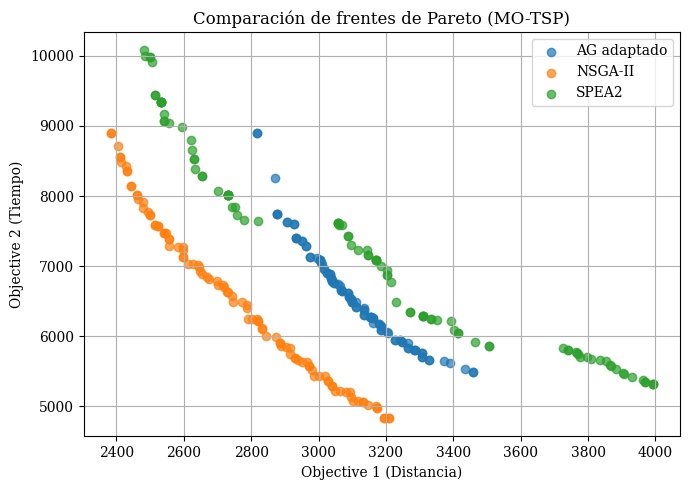

In [61]:
plt.figure(figsize=(7, 5))

plt.scatter(
    F_ours_pareto[:, 0],
    F_ours_pareto[:, 1],
    label="AG adaptado",
    alpha=0.7
)

plt.scatter(
    F_nsga2_pareto[:, 0],
    F_nsga2_pareto[:, 1],
    label="NSGA-II",
    alpha=0.7
)

plt.scatter(
    F_spea2_pareto[:, 0],
    F_spea2_pareto[:, 1],
    label="SPEA2",
    alpha=0.7
)

plt.xlabel("Objective 1 (Distancia)")
plt.ylabel("Objective 2 (Tiempo)")
plt.title("Comparación de frentes de Pareto (MO-TSP)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Métricas finales

In [62]:
def get_pareto_front(F):
    nds = NonDominatedSorting()
    idx = nds.do(F, only_non_dominated_front=True)
    return F[idx]


In [64]:
n_runs = 10
results = []

for run in range(n_runs):
    np.random.seed(run)

    pop, F = evolve(
        problem=problem,
        max_evals=100_000,
        n_individuals=100,
        crossover_op=sbx_crossover,
        mutation_op=polynomial_mutation,
        pcross=0.9,
        pmut=0.01,
        T=2,
        elitism=True,
        crossover_params={"eta_c": 20},
        mutation_params={"eta_m": 20}
    )

    F_pareto = get_pareto_front(F)
    results.append(("GA", run, F_pareto))

Gen 1 | Evals 212/100000 | No dominadas: 12
Gen 100 | Evals 13699/100000 | No dominadas: 86
Gen 200 | Evals 32449/100000 | No dominadas: 100
Gen 300 | Evals 51242/100000 | No dominadas: 67
Gen 400 | Evals 70739/100000 | No dominadas: 100
Gen 500 | Evals 90328/100000 | No dominadas: 100
Gen 1 | Evals 206/100000 | No dominadas: 6
Gen 100 | Evals 13770/100000 | No dominadas: 79
Gen 200 | Evals 30525/100000 | No dominadas: 100
Gen 300 | Evals 48873/100000 | No dominadas: 100
Gen 400 | Evals 68340/100000 | No dominadas: 100
Gen 500 | Evals 88273/100000 | No dominadas: 100
Gen 1 | Evals 207/100000 | No dominadas: 7
Gen 100 | Evals 13694/100000 | No dominadas: 76
Gen 200 | Evals 32079/100000 | No dominadas: 98
Gen 300 | Evals 51149/100000 | No dominadas: 80
Gen 400 | Evals 71062/100000 | No dominadas: 100
Gen 500 | Evals 91056/100000 | No dominadas: 100
Gen 1 | Evals 208/100000 | No dominadas: 8
Gen 100 | Evals 13241/100000 | No dominadas: 16
Gen 200 | Evals 29181/100000 | No dominadas: 43
Ge

In [65]:
for run in range(n_runs):
    # NSGA-II
    res_nsga2 = minimize(
        problem,
        NSGA2(pop_size=100),
        termination=("n_eval", 100_000),
        seed=run,
        verbose=False
    )
    results.append(("NSGA-II", run, res_nsga2.F))

    # SPEA2
    res_spea2 = minimize(
        problem,
        SPEA2(pop_size=100),
        termination=("n_eval", 100_000),
        seed=run,
        verbose=False
    )
    results.append(("SPEA2", run, res_spea2.F))

In [66]:
all_fronts = [r[2] for r in results]
ref_point = compute_reference_point(*all_fronts)

In [67]:
rows = []

for algo, run, F in results:
    hv, spr, spa = calculate_metrics(F, ref_point)

    rows.append({
        "algorithm": algo,
        "run": run,
        "hv": hv,
        "spr": spr,
        "spa": spa,
        "n_pareto": len(F)
    })

df_results = pd.DataFrame(rows)
df_results

,algorithm,run,hv,spr,spa,n_pareto
0,GA,0,1.140415e+07,2116.808972,5.042023,100
1,GA,1,1.003382e+07,5169.757259,12.635885,100
2,GA,2,1.122190e+07,4197.775379,7.302187,100
3,GA,3,1.118393e+07,4111.092331,7.146760,100
4,GA,4,9.034686e+06,3784.280779,14.746556,99
5,GA,5,1.029942e+07,3315.203584,4.495229,100
6,GA,6,1.083420e+07,3114.612160,6.120879,100
7,GA,7,1.215194e+07,2947.638833,5.145162,100
8,GA,8,1.087692e+07,2920.409314,9.894762,100
9,GA,9,1.048931e+07,4558.574421,16.003691,100


In [68]:
df_results_final = df_results.groupby("algorithm")[["hv", "spr", "spa"]].agg(["mean", "std"])
df_results_final

hv                        spr                    spa  \
                   mean           std         mean         std       mean   
algorithm                                                                   
GA         1.075303e+07  8.533353e+05  3623.615303  908.840574   8.853314   
NSGA-II    1.304396e+07  1.034575e+06  4504.665046  914.264428  15.833438   
SPEA2      1.351426e+07  1.164686e+06  4809.102360  520.063614  24.568067   

                     
                std  
algorithm            
GA         4.233522  
NSGA-II    7.719089  
SPEA2      5.022805